In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

2025-01-22 13:40:01.060993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 13:40:01.069854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737533401.080411    7333 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737533401.083625    7333 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 13:40:01.095257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

fatal: destination path 'Brain-Tumor-Classification-DataSet' already exists and is not an empty directory.


In [3]:
data_dir = "/home/pes1ug22am100/Documents/Research and Experimentation/neuralNeurosis/Brain-Tumor-Classification-DataSet"
img_size = (224, 224)
batch_size = 32

In [4]:
def prepare_data(train_dir, test_dir, img_size, batch_size):
    train_datagen = ImageDataGenerator(rescale=1.0/255)
    test_datagen = ImageDataGenerator(rescale=1.0/255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
    )

    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    return train_gen, test_gen

In [5]:
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")
train_gen, test_gen = prepare_data(train_dir, test_dir, img_size, batch_size)
num_classes = len(train_gen.class_indices)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [6]:
print(f"Number of classes: {len(train_gen.class_indices)}")
print(f"Class labels: {train_gen.class_indices}")

Number of classes: 4
Class labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [16]:
# def visualize_encoding(image_path, encoding_type='rate', time_window=100, max_spikes=20):
#     if encoding_type == 'rate':
#         encode_function = encode_rate_coding
#     elif encoding_type == 'temporal':
#         encode_function = encode_temporal_coding
#     else:
#         raise ValueError(f"Unsupported encoding type: {encoding_type}")
    
#     spike_train = encode_function(image_path, time_window, max_spikes)
    
#     img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
#     img_array = np.array(img) / 255.0
    
#     plt.figure(figsize=(10, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.imshow(img_array, cmap='gray')
#     plt.title('Original MRI Image')
    
#     plt.subplot(1, 2, 2)
#     if encoding_type == 'rate':
#         plt.imshow(np.sum(spike_train, axis=2), cmap='hot', interpolation='nearest')
#         plt.title('Rate Coding Encoded Image')
#     elif encoding_type == 'temporal':
#         plt.imshow(np.argmax(spike_train, axis=2), cmap='hot', interpolation='nearest')
#         plt.title('Temporal Coding Encoded Image')
    
#     plt.colorbar()
#     plt.show()

def visualize_encoding(image_path, encoding_type='rate', time_window=100, max_spikes=20):
    if encoding_type == 'rate':
        encode_function = encode_rate_coding
    elif encoding_type == 'temporal':
        encode_function = encode_temporal_coding  # temporal encoding does not use max_spikes
    else:
        raise ValueError(f"Unsupported encoding type: {encoding_type}")
    
    # Only pass the required parameters for the selected encoding type
    if encoding_type == 'temporal':
        spike_train = encode_function(image_path, time_window)  # No max_spikes for temporal coding
    else:
        spike_train = encode_function(image_path, time_window, max_spikes)  # Pass max_spikes for rate coding
    
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = np.array(img) / 255.0
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title('Original MRI Image')
    
    plt.subplot(1, 2, 2)
    if encoding_type == 'rate':
        plt.imshow(np.sum(spike_train, axis=2), cmap='hot', interpolation='nearest')
        plt.title('Rate Coding Encoded Image')
    elif encoding_type == 'temporal':
        plt.imshow(np.argmax(spike_train, axis=2), cmap='hot', interpolation='nearest')
        plt.title('Temporal Coding Encoded Image')
    
    plt.colorbar()
    plt.show()


In [8]:
def encode_rate_coding(image_path, time_window=100, max_spikes=20):
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = np.array(img) / 255.0

    spike_train = np.zeros((img_array.shape[0], img_array.shape[1], time_window))

    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            num_spikes = int(img_array[i, j] * max_spikes)
            spike_train[i, j, :num_spikes] = 1

    return spike_train

# Rate Encoding Concept
# In rate coding, the information is encoded in the firing rate of the neurons.
# The more intense the input, the higher the rate of spikes within a fixed time window.

In [9]:
def random_class_sample(train_gen, encoding_type='rate', num_samples=1, time_window=100, max_spikes=20):
    class_names = list(train_gen.class_indices.keys())
    
    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        images = os.listdir(class_dir)
        
        random_image = random.choice(images)
        image_path = os.path.join(class_dir, random_image)
        
        print(f"Displaying sample from class: {class_name}")
        
        visualize_encoding(image_path, encoding_type, time_window, max_spikes)

In [10]:
def encode_temporal_coding(image_path, time_window=100):
    # Load and normalize the image
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

    # Initialize spike train
    spike_train = np.zeros((img_array.shape[0], img_array.shape[1], time_window))

    # Map pixel intensities to spike times (higher intensity = earlier spike)
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            if img_array[i, j] > 0:  # Only encode non-zero intensity pixels
                spike_time = int((1 - img_array[i, j]) * (time_window - 1))  # Inverse mapping
                spike_train[i, j, spike_time] = 1  # Set the first spike

    return spike_train


# Temporal Encoding Concept
# In temporal coding, the information is encoded in the timing of the first spike.
# The pixel intensity determines the time at which a spike occurs within a time window.

In [11]:
def visualize_temporal_encoding(image_path, time_window=100):
    """
    Visualizes the temporal encoding of an image.
    
    :param image_path: Path to the input image.
    :param time_window: Total time window for encoding (number of time steps).
    """
    # Encode the image using temporal coding
    spike_train = encode_temporal_coding(image_path, time_window)

    # Load and normalize the original image
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = np.array(img) / 255.0

    # Create a figure to display results
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title('Original MRI Image')

    # Temporal Encoding Visualization
    plt.subplot(1, 2, 2)
    plt.imshow(np.argmax(spike_train, axis=2), cmap='hot', interpolation='nearest')
    plt.title('Temporal Coding Encoded Image')
    
    plt.colorbar()
    plt.show()

Visualizing random samples with Rate Encoding:
Displaying sample from class: glioma_tumor


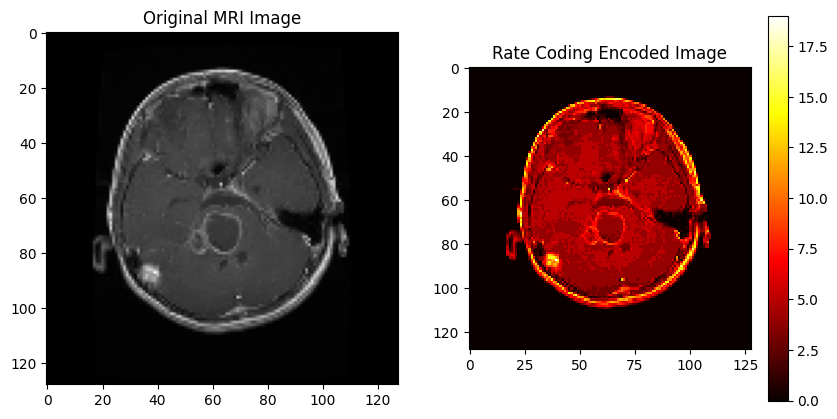

Displaying sample from class: meningioma_tumor


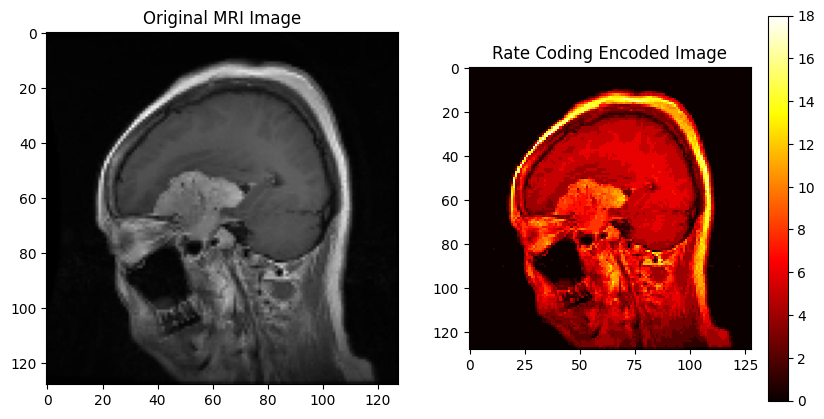

Displaying sample from class: no_tumor


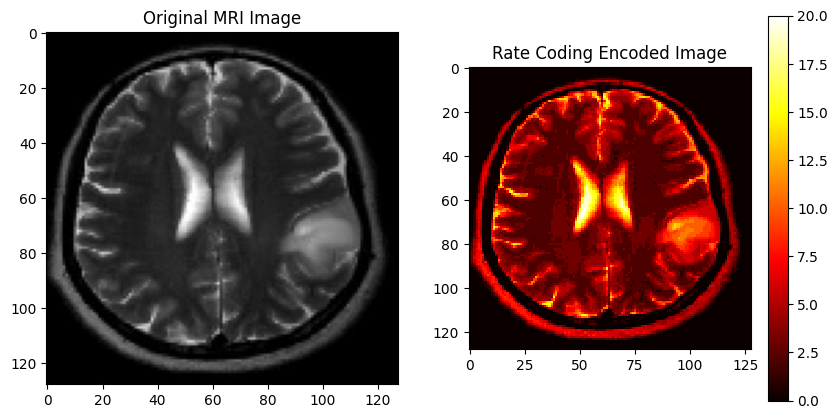

Displaying sample from class: pituitary_tumor


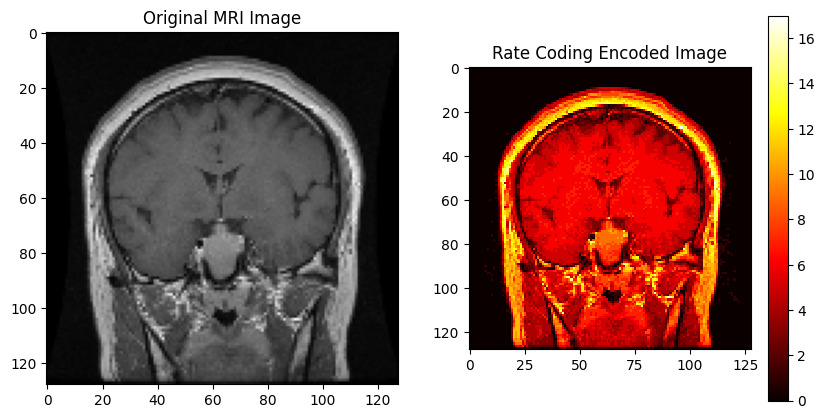

Visualizing random samples with Temporal Encoding:
Displaying sample from class: glioma_tumor


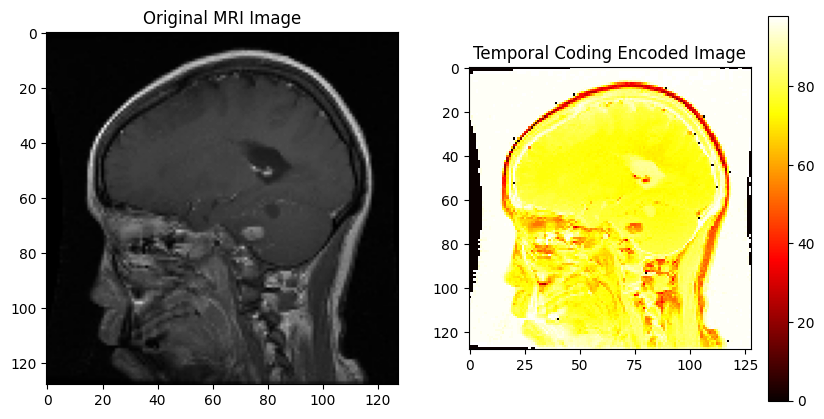

Displaying sample from class: meningioma_tumor


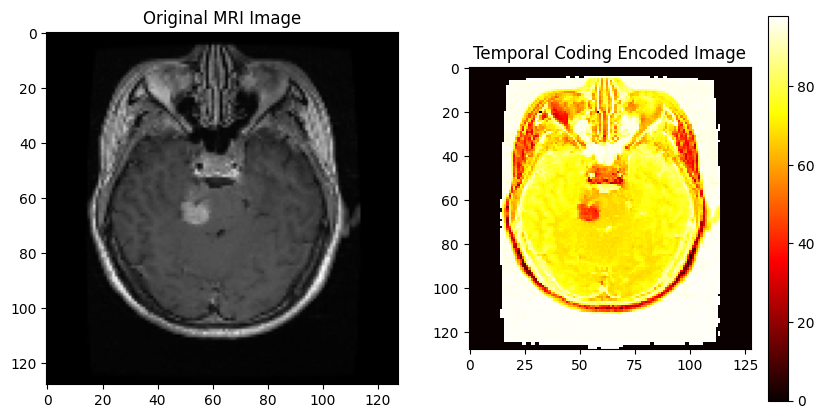

Displaying sample from class: no_tumor


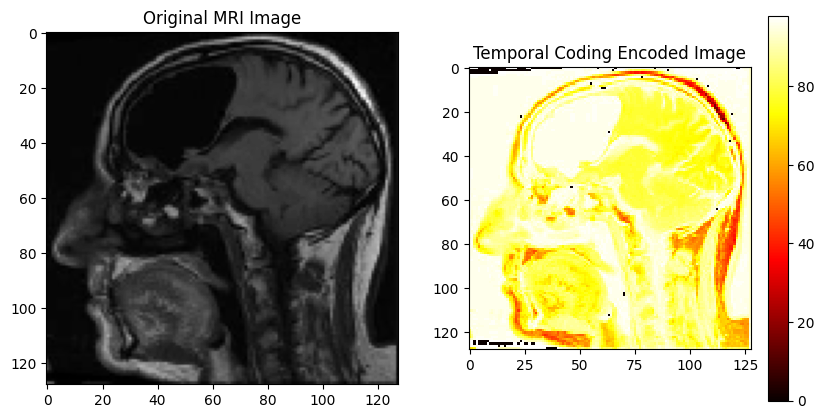

Displaying sample from class: pituitary_tumor


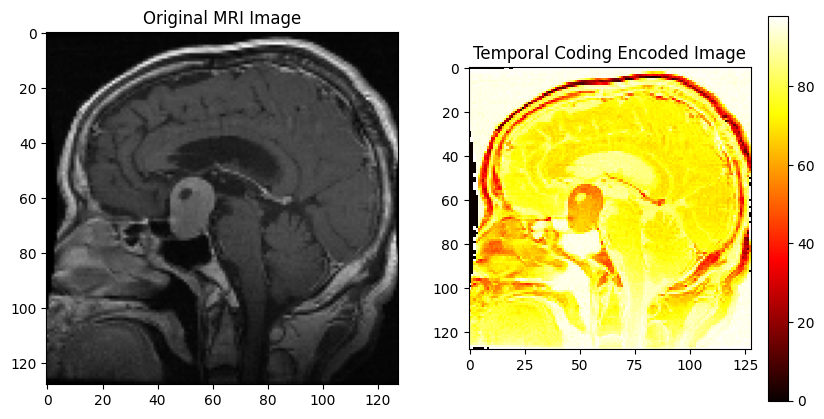

In [17]:
# Visualize random samples with rate encoding
print("Visualizing random samples with Rate Encoding:")
random_class_sample(train_gen, encoding_type='rate', num_samples=1)

# Visualize random samples with temporal encoding
print("Visualizing random samples with Temporal Encoding:")
random_class_sample(train_gen, encoding_type='temporal', num_samples=1)
